In [12]:
# Colab-friendly installs
!pip -q install --upgrade pip
!pip -q install yfinance pandas_market_calendars --upgrade

In [13]:
import os, sys, platform, warnings, random, subprocess, textwrap
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import yfinance as yf
import pandas_market_calendars as mcal
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics, backend as K

# Versions (helps debugging/repro)
print("Python      :", sys.version.split()[0])
print("OS          :", platform.platform())
print("NumPy       :", np.__version__)
print("Pandas      :", pd.__version__)
print("Matplotlib  :", matplotlib.__version__)
print("scikit-learn:", __import__('sklearn').__version__)
print("TensorFlow  :", tf.__version__)
print("yfinance    :", yf.__version__)
print("pandas_market_calendars:", mcal.__version__)

warnings.filterwarnings("ignore")


Python      : 3.13.5
OS          : Windows-11-10.0.26100-SP0
NumPy       : 2.3.3
Pandas      : 2.3.2
Matplotlib  : 3.10.6
scikit-learn: 1.7.2
TensorFlow  : 2.20.0
yfinance    : 0.2.65
pandas_market_calendars: 5.1.1


In [14]:
# Repro seeds (best-effort determinism)
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Device info
print("GPUs:", tf.config.list_physical_devices('GPU'))
try:
    out = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
    print(textwrap.shorten(out.stdout, width=1000, placeholder="..."))
except Exception:
    print("nvidia-smi not available (CPU runtime is fine).")

print("✅ Step 1 ready: env + imports OK")


GPUs: []
nvidia-smi not available (CPU runtime is fine).
✅ Step 1 ready: env + imports OK


In [15]:
import pandas as pd
import numpy as np
import datetime as dt

# === USER CONFIG (edit these) ===
TICKER        = "AAPL"          # e.g., "AAPL", "MSFT", "TSLA"
START         = "2010-01-01"    # we’ll trim to recent years below
END           = None            # None => last completed UTC day (avoids partial candles)
TRIM_YEARS    = 10              # keep only the last N years to reduce non-stationarity
LOOKBACK      = 90             # timesteps per sample (try 60–90)
N_FUTURE      = 14              # forecast horizon (we’ll predict next-day returns and roll forward)
CALENDAR      = "XNYS"          # trading calendar (NYSE)

# === TARGET/FEATURE MODE (fixed for this run) ===
FEATURE_SET   = "univariate_close"  # inputs will be single series
TARGET_MODE   = "log_return"        # we predict next-day log return, not price

# === GUARDRAILS ===
MIN_LOOKBACK      = 20
MAX_FUTURE_DAYS   = 252
RANDOM_SEED       = 42

# Placeholder for derived values
CONFIG_SUMMARY = {}


In [16]:
# ---------- tz-safe date helpers ----------
def _last_completed_utc_day():
    # use the previous full UTC day to avoid partial/intraday bars
    return (pd.Timestamp.utcnow().normalize() - pd.Timedelta(days=1))

def _utc_midnight_naive(ts):
    ts = pd.Timestamp(ts)
    if ts.tzinfo is None or ts.tz is None:
        ts = ts.tz_localize("UTC")
    else:
        ts = ts.tz_convert("UTC")
    # normalize to midnight UTC, then return tz-naive for yfinance
    return ts.normalize().tz_localize(None)

def _resolve_dates(start, end):
    s = pd.Timestamp(start) if start is not None else pd.Timestamp("2000-01-01")
    e = pd.Timestamp(end)   if end   is not None else _last_completed_utc_day()
    s = _utc_midnight_naive(s)
    e = _utc_midnight_naive(e)
    if s >= e:
        raise ValueError(f"START ({s.date()}) must be < END ({e.date()}).")
    return s, e

# ---------- config validation ----------
def _validate_core():
    if not isinstance(TICKER, str) or not TICKER.strip():
        raise ValueError("TICKER must be a non-empty string.")
    if LOOKBACK < MIN_LOOKBACK:
        raise ValueError(f"LOOKBACK must be ≥ {MIN_LOOKBACK}.")
    if not (1 <= int(N_FUTURE) <= MAX_FUTURE_DAYS):
        raise ValueError(f"N_FUTURE must be in [1, {MAX_FUTURE_DAYS}].")
    if TARGET_MODE not in {"log_return"}:
        raise ValueError('TARGET_MODE must be "log_return" for this pipeline.')
    if FEATURE_SET not in {"univariate_close"}:
        raise ValueError('FEATURE_SET must be "univariate_close" for this pipeline.')
    if not isinstance(TRIM_YEARS, int) or TRIM_YEARS < 3:
        raise ValueError("TRIM_YEARS should be an integer ≥ 3.")
    if not isinstance(CALENDAR, str) or not CALENDAR.strip():
        raise ValueError("CALENDAR must be a non-empty string (e.g., 'XNYS').")

# ---------- run validations & derive ----------
_validate_core()
START_DT, END_DT = _resolve_dates(START, END)

# In univariate mode we only fetch/use Close; we’ll compute returns later
FETCH_COLS      = ["Close"]
MODEL_FEATURES  = ["Close"]  # inputs will be returns derived from Close
TARGET_COLUMN   = "Close"    # the price we’ll transform to returns

CONFIG_SUMMARY = {
    "ticker": TICKER.upper(),
    "start": str(START_DT.date()),
    "end": str(END_DT.date()),
    "feature_set": FEATURE_SET,
    "target_mode": TARGET_MODE,
    "lookback": LOOKBACK,
    "n_future": N_FUTURE,
    "calendar": CALENDAR,
    "trim_years": TRIM_YEARS,
    "model_features": MODEL_FEATURES,
    "target_column": TARGET_COLUMN,
    "random_seed": RANDOM_SEED,
}

print("✅ Config validated (univariate + log-return).")
for k, v in CONFIG_SUMMARY.items():
    print(f"{k:>14}: {v}")


✅ Config validated (univariate + log-return).
        ticker: AAPL
         start: 2010-01-01
           end: 2025-09-13
   feature_set: univariate_close
   target_mode: log_return
      lookback: 90
      n_future: 14
      calendar: XNYS
    trim_years: 10
model_features: ['Close']
 target_column: Close
   random_seed: 42


In [17]:
import pandas as pd
import yfinance as yf
import pandas_market_calendars as mcal
import time

def _flatten_columns(cols, ticker_expected=None):
    """Flatten possible MultiIndex columns from yfinance."""
    if isinstance(cols, pd.MultiIndex):
        if cols.nlevels == 2:
            second = {t for (_, t) in cols}
            if len(second) == 1 and (ticker_expected is None or list(second)[0] == ticker_expected):
                flat = [str(f) for (f, _) in cols]
            else:
                flat = ["_".join([str(x) for x in tup if x is not None]) for tup in cols]
        else:
            flat = ["_".join([str(x) for x in tup if x is not None]) for tup in cols]
    else:
        flat = [str(c) for c in cols]
    return [c.strip().title().replace(" ", "_") for c in flat]

def fetch_ohlc_yf(
    ticker: str,
    start_dt: pd.Timestamp,
    end_dt: pd.Timestamp,
    auto_adjust: bool = True,
    max_retries: int = 3,
    sleep_sec: float = 1.5,
) -> pd.DataFrame:
    """Download OHLCV and align to exchange trading days. Returns tz-naive, strictly increasing index."""
    start_s, end_s = str(start_dt.date()), str(end_dt.date())
    last_err = None

    for attempt in range(1, max_retries + 1):
        try:
            df = yf.download(
                tickers=ticker,
                start=start_s,
                end=end_s,
                auto_adjust=auto_adjust,
                progress=False,
                threads=True,
                group_by="column",
            )
            if df is None or df.empty:
                raise ValueError(f"No data for {ticker} between {start_s} and {end_s}")

            # Normalize index to tz-naive, unique, increasing
            df.index = pd.to_datetime(df.index, utc=False)
            if getattr(df.index, "tz", None) is not None:
                df.index = df.index.tz_localize(None)
            df = df.sort_index().loc[~df.index.duplicated(keep="first")]

            # Flatten possible MultiIndex columns, standardize names
            df.columns = _flatten_columns(df.columns, ticker_expected=ticker.upper())

            # Enforce numeric and drop all-NaN rows
            for c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce")
            df = df.dropna(how="all")

            # Align to trading days for the chosen calendar
            cal = mcal.get_calendar(CALENDAR)
            sched = cal.schedule(start_date=start_s, end_date=end_s)
            trading_days = sched.index
            if getattr(trading_days, "tz", None) is not None:
                trading_days = trading_days.tz_localize(None)
            trading_days = pd.DatetimeIndex(trading_days)

            df = df.loc[df.index.intersection(trading_days)]

            # Final guards
            if not df.index.is_monotonic_increasing:
                raise ValueError("Index is not strictly increasing after sorting.")
            if "Close" not in df.columns:
                raise ValueError(f"'Close' column missing. Got: {list(df.columns)}")
            if df["Close"].isna().any():
                df = df.dropna(subset=["Close"])
            if df.empty:
                raise ValueError("All rows dropped; no usable data.")

            return df

        except Exception as e:
            last_err = e
            if attempt < max_retries:
                time.sleep(sleep_sec)
            else:
                raise RuntimeError(f"Fetch failed after {max_retries} attempts: {e}") from e

# Run the fetch
raw_df = fetch_ohlc_yf(TICKER, START_DT, END_DT, auto_adjust=True)
print(f"✅ Downloaded {TICKER}: {raw_df.shape[0]} rows")
print("Columns:", list(raw_df.columns))
print("Range  :", raw_df.index.min().date(), "→", raw_df.index.max().date())


✅ Downloaded AAPL: 3948 rows
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Range  : 2010-01-04 → 2025-09-12


In [18]:
# Univariate base: just Close
close_df = raw_df[["Close"]].copy()

# Trim to recent history to reduce non-stationarity
cutoff = close_df.index.max() - pd.DateOffset(years=TRIM_YEARS)
close_df = close_df[close_df.index >= cutoff].copy()

print(f"Using last {TRIM_YEARS} years → rows: {close_df.shape[0]}")
print("Range:", close_df.index.min().date(), "→", close_df.index.max().date())
print(close_df.tail(3))

# Guardrail: enough history for lookback, horizon, and evaluation buffer
TOTAL_MIN_ROWS = LOOKBACK + N_FUTURE + 200   # extra buffer keeps splits robust
if close_df.shape[0] < TOTAL_MIN_ROWS:
    raise ValueError(
        f"Not enough rows after trim. Have {close_df.shape[0]}, need ≥ {TOTAL_MIN_ROWS}. "
        f"Try smaller LOOKBACK/N_FUTURE or increase TRIM_YEARS."
    )

# Invariants
assert isinstance(close_df.index, pd.DatetimeIndex)
assert close_df.index.tz is None, "Index must be tz-naive."
assert close_df.index.is_monotonic_increasing, "Index must be strictly increasing."
assert np.issubdtype(close_df["Close"].dtype, np.number), "Close must be numeric."

print("✅ Base series ready for return computation.")


Using last 10 years → rows: 2515
Range: 2015-09-14 → 2025-09-12
                 Close
2025-09-10  226.789993
2025-09-11  230.029999
2025-09-12  234.070007
✅ Base series ready for return computation.


In [19]:
import numpy as np
import pandas as pd

# Log return r_t = ln(C_t / C_{t-1})
ret_df = pd.DataFrame({
    "LogRet": np.log(close_df["Close"]).diff()
}).dropna()

# Guardrail: enough rows after diff
TOTAL_MIN_ROWS = LOOKBACK + N_FUTURE + 200   # buffer for stable splits/val
if ret_df.shape[0] < TOTAL_MIN_ROWS:
    raise ValueError(
        f"Not enough rows after log-return diff. Have {ret_df.shape[0]}, need ≥ {TOTAL_MIN_ROWS}. "
        f"Try smaller LOOKBACK/N_FUTURE or increase TRIM_YEARS."
    )

# Invariants
assert isinstance(ret_df.index, pd.DatetimeIndex)
assert ret_df.index.tz is None, "Index must be tz-naive."
assert ret_df.index.is_monotonic_increasing, "Index must be strictly increasing."
assert np.issubdtype(ret_df["LogRet"].dtype, np.number), "LogRet must be numeric."
assert not ret_df["LogRet"].isna().any(), "No NaNs allowed after diff().dropna()."

print("✅ Log-return series ready:", ret_df.shape)
print("Range:", ret_df.index.min().date(), "→", ret_df.index.max().date())
ret_df.tail(3)


✅ Log-return series ready: (2514, 1)
Range: 2015-09-15 → 2025-09-12


,LogRet
2025-09-10,-0.032791
2025-09-11,0.014185
2025-09-12,0.017411


,count,mean,std,min,25%,50%,75%,max,missing
LogRet,2514.0,0.000875,0.018358,-0.137708,-0.007425,0.00097,0.010083,0.142617,0


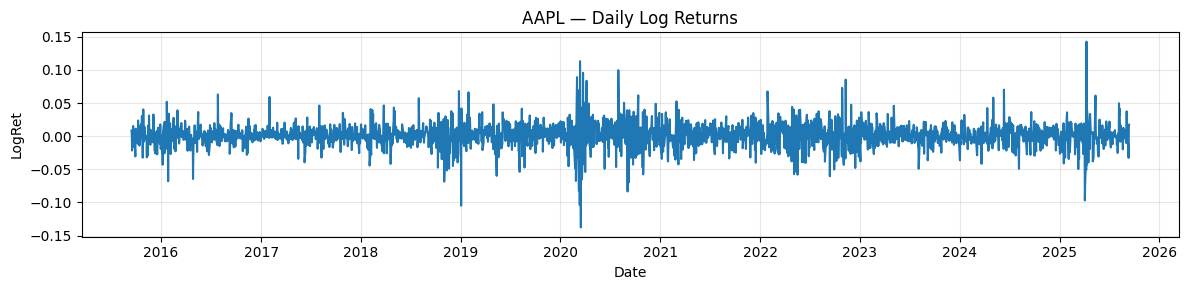

In [20]:
# Descriptive stats
desc = ret_df.describe().T
desc["missing"] = ret_df.isna().sum()
display(desc)

# Tiny visual to confirm no wild artifacts
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(ret_df.index, ret_df["LogRet"])
plt.title(f"{TICKER} — Daily Log Returns")
plt.xlabel("Date"); plt.ylabel("LogRet")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


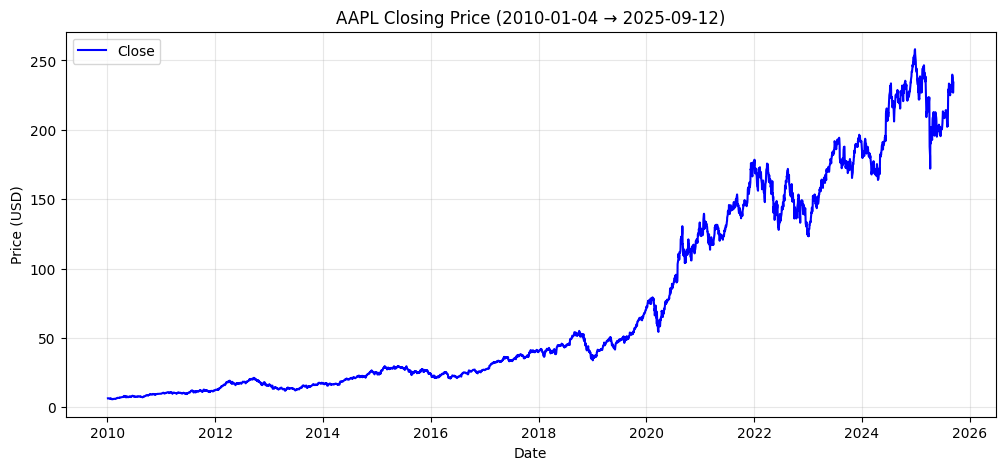

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(raw_df.index, raw_df["Close"], label="Close", color="blue")
plt.title(f"{TICKER} Closing Price ({raw_df.index.min().date()} → {raw_df.index.max().date()})")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# If multivariate, plot Open/High/Low too
if FEATURE_SET == "multivariate":
    plt.figure(figsize=(12, 5))
    for col in ["Open", "High", "Low"]:
        if col in raw_df.columns:
            plt.plot(raw_df.index, raw_df[col], label=col)
    plt.title(f"{TICKER} OHLC Prices")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


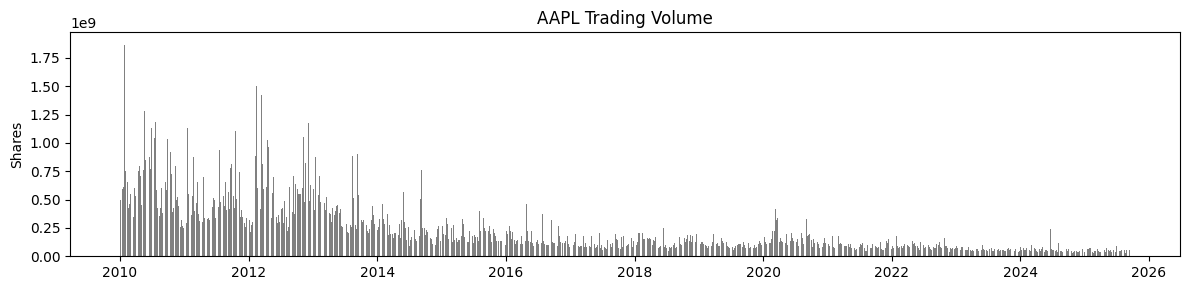

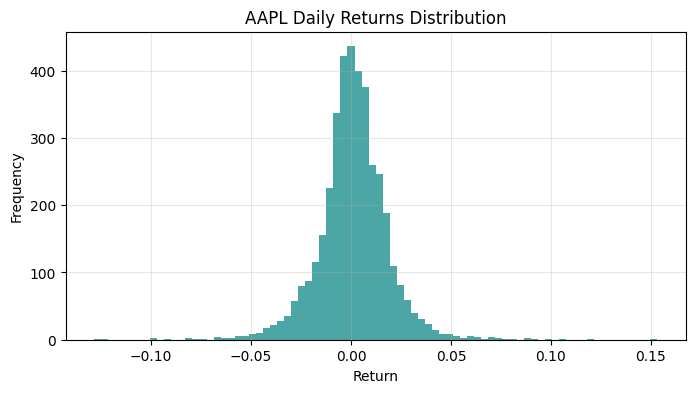

In [22]:
# Volume plot (if available)
if "Volume" in raw_df.columns:
    plt.figure(figsize=(12, 3))
    plt.bar(raw_df.index, raw_df["Volume"], width=1.0, color="gray")
    plt.title(f"{TICKER} Trading Volume")
    plt.ylabel("Shares")
    plt.tight_layout()
    plt.show()

# Simple daily returns distribution
returns = raw_df["Close"].pct_change().dropna()
plt.figure(figsize=(8, 4))
plt.hist(returns, bins=80, alpha=0.7, color="teal")
plt.title(f"{TICKER} Daily Returns Distribution")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

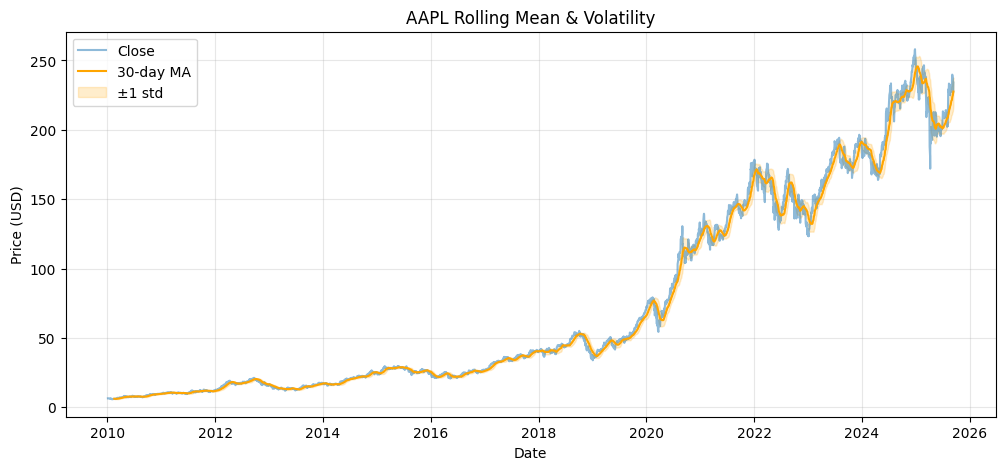

In [26]:
# Rolling mean & std to check stability
window = 30  # 30 trading days ~ 1.5 months
rolling_mean = raw_df["Close"].rolling(window).mean()
rolling_std = raw_df["Close"].rolling(window).std()

plt.figure(figsize=(12, 5))
plt.plot(raw_df.index, raw_df["Close"], label="Close", alpha=0.5)
plt.plot(rolling_mean, label=f"{window}-day MA", color="orange")
plt.fill_between(raw_df.index,
                 rolling_mean - rolling_std,
                 rolling_mean + rolling_std,
                 color="orange", alpha=0.2, label="±1 std")
plt.title(f"{TICKER} Rolling Mean & Volatility")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


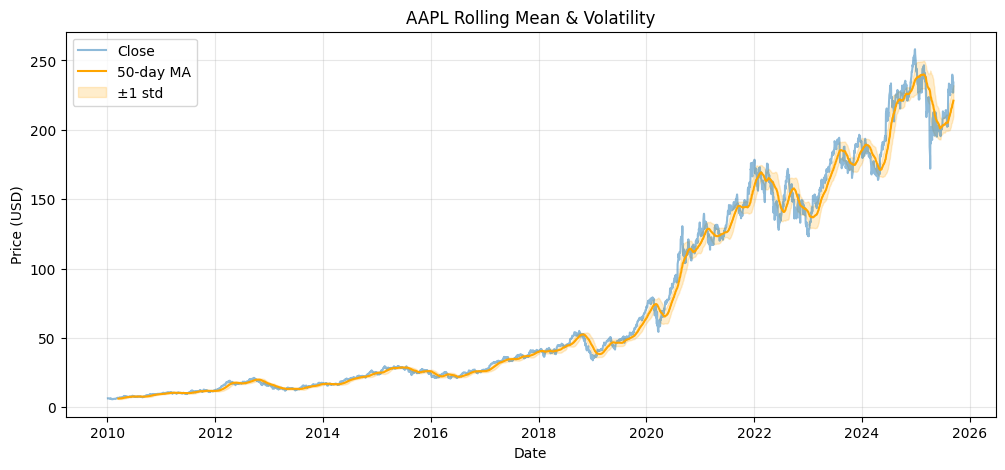

In [28]:
window = 50  # 30 trading days ~ 1.5 months
rolling_mean = raw_df["Close"].rolling(window).mean()
rolling_std = raw_df["Close"].rolling(window).std()

plt.figure(figsize=(12, 5))
plt.plot(raw_df.index, raw_df["Close"], label="Close", alpha=0.5)
plt.plot(rolling_mean, label=f"{window}-day MA", color="orange")
plt.fill_between(raw_df.index,
                 rolling_mean - rolling_std,
                 rolling_mean + rolling_std,
                 color="orange", alpha=0.2, label="±1 std")
plt.title(f"{TICKER} Rolling Mean & Volatility")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

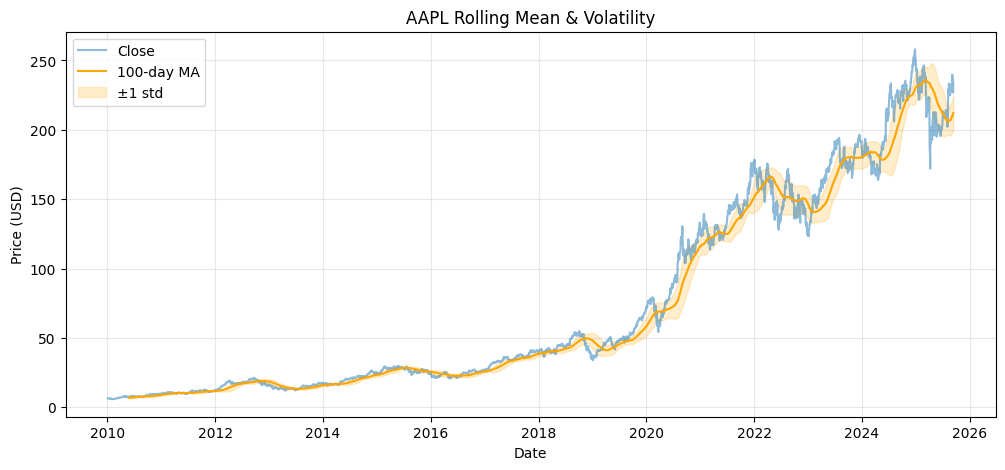

In [29]:
window = 100 # 30 trading days ~ 1.5 months
rolling_mean = raw_df["Close"].rolling(window).mean()
rolling_std = raw_df["Close"].rolling(window).std()

plt.figure(figsize=(12, 5))
plt.plot(raw_df.index, raw_df["Close"], label="Close", alpha=0.5)
plt.plot(rolling_mean, label=f"{window}-day MA", color="orange")
plt.fill_between(raw_df.index,
                 rolling_mean - rolling_std,
                 rolling_mean + rolling_std,
                 color="orange", alpha=0.2, label="±1 std")
plt.title(f"{TICKER} Rolling Mean & Volatility")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
# ret_df has one column: "LogRet", already time-indexed
n = len(ret_df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_df = ret_df.iloc[:train_end].copy()
val_df   = ret_df.iloc[train_end:val_end].copy()
test_df  = ret_df.iloc[val_end:].copy()

print(f"Rows → Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print("Train range:", train_df.index.min().date(), "→", train_df.index.max().date())
print("Val   range:", val_df.index.min().date(),   "→", val_df.index.max().date())
print("Test  range:", test_df.index.min().date(),  "→", test_df.index.max().date())


Rows → Train: 1759 | Val: 377 | Test: 378
Train range: 2015-09-15 → 2022-09-08
Val   range: 2022-09-09 → 2024-03-11
Test  range: 2024-03-12 → 2025-09-12


In [30]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

scaler = StandardScaler()

# Fit ONLY on train, then transform all splits
scaler.fit(train_df[["LogRet"]])

train_scaled = pd.DataFrame(
    scaler.transform(train_df[["LogRet"]]),
    index=train_df.index, columns=["LogRet"]
)
val_scaled = pd.DataFrame(
    scaler.transform(val_df[["LogRet"]]),
    index=val_df.index, columns=["LogRet"]
)
test_scaled = pd.DataFrame(
    scaler.transform(test_df[["LogRet"]]),
    index=test_df.index, columns=["LogRet"]
)

# Sanity: train should be ~N(0,1)
print("Scaler mean_ (train):", scaler.mean_)
print("Scaler scale_ (train):", scaler.scale_)
print("Train scaled mean/std:", float(train_scaled.mean()), float(train_scaled.std()))

# Tiny peek
print("✅ Scaling done. Last few of val split:")
display(val_scaled.tail(3))


Scaler mean_ (train): [0.00100598]
Scaler scale_ (train): [0.0186605]
Train scaled mean/std: 1.615787915315748e-17 1.000284373672747
✅ Scaling done. Last few of val split:


,LogRet
2024-03-07,-0.091942
2024-03-08,0.491867
2024-03-11,0.576421


In [31]:
import numpy as np
import pandas as pd

# Previous-day close aligned to each return timestamp t:
# For return at date t (LogRet_t = ln(C_t / C_{t-1})), we need C_{t-1} to reconstruct Ĉ_t.
last_close_series = (
    close_df["Close"]
    .reindex(ret_df.index)     # align by dates used in ret_df
    .shift(1)                  # previous trading day close
)

def create_sequences(data: pd.DataFrame,
                     lookback: int,
                     last_close_aligned: pd.Series | None = None,
                     col: str = "LogRet"):
    """
    data: scaled DataFrame with a single column (LogRet), already split (train/val/test)
    last_close_aligned: Series of previous-day Close aligned to data.index (optional)
    Returns: (X, y, last_close_for_y) where last_close_for_y is None if not provided
    """
    X, y, lc = [], [], []
    values = data[col].values  # 1D
    for i in range(lookback, len(values)):
        X.append(values[i - lookback:i].reshape(lookback, 1))
        y.append(values[i])
        if last_close_aligned is not None:
            lc_val = last_close_aligned.iloc[i]
            lc.append(float(lc_val) if pd.notna(lc_val) else np.nan)

    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)
    lc = (np.asarray(lc, dtype=np.float32) if last_close_aligned is not None else None)
    return X, y, lc

# Build sequences for each split (pass the aligned last-close for later price reconstruction)
X_train, y_train, lc_train = create_sequences(train_scaled, LOOKBACK, last_close_series.loc[train_df.index])
X_val,   y_val,   lc_val   = create_sequences(val_scaled,   LOOKBACK, last_close_series.loc[val_df.index])
X_test,  y_test,  lc_test  = create_sequences(test_scaled,  LOOKBACK, last_close_series.loc[test_df.index])

print("✅ Sequences built (LogRet → next-day LogRet). Shapes:")
print("  Train:", X_train.shape, y_train.shape, "| last_close:", None if lc_train is None else lc_train.shape)
print("  Val  :", X_val.shape,   y_val.shape,   "| last_close:", None if lc_val   is None else lc_val.shape)
print("  Test :", X_test.shape,  y_test.shape,  "| last_close:", None if lc_test  is None else lc_test.shape)

# Basic sanity checks
assert X_train.shape[-1] == 1, "Univariate sequences must have 1 feature."
assert not np.isnan(y_train).any() and not np.isnan(X_train).any(), "NaNs in training sequences."
if lc_train is not None:
    # First few should be valid (lookback ensures shift NaN is out of range)
    assert not np.isnan(lc_train[:5]).any(), "Found NaNs in aligned previous-day Close for training."


✅ Sequences built (LogRet → next-day LogRet). Shapes:
  Train: (1669, 90, 1) (1669,) | last_close: (1669,)
  Val  : (287, 90, 1) (287,) | last_close: (287,)
  Test : (288, 90, 1) (288,) | last_close: (288,)


In [32]:
print("One sample shapes:")
print("  X_train[0]:", X_train[0].shape, "→ first 5 timesteps:", X_train[0][:5, 0])
print("  y_train[0] (scaled LogRet):", y_train[0])

# (Optional) show the corresponding previous-day close used for reconstructing price later
if lc_train is not None:
    print("  prev-day Close for this target:", lc_train[0])


One sample shapes:
  X_train[0]: (90, 1) → first 5 timesteps: [ 0.3950089   0.00596613 -1.2126172  -0.27546456  0.7710563 ]
  y_train[0] (scaled LogRet): -1.1104568
  prev-day Close for this target: 22.889221


In [33]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics, backend as K, regularizers
import tensorflow as tf

# Safety: confirm shapes from Step 6
assert X_train.ndim == 3 and X_train.shape[1] == LOOKBACK, "X_train shape mismatch."
N_FEATURES = X_train.shape[2]
print(f"LOOKBACK={LOOKBACK}, N_FEATURES={N_FEATURES} (should be 1 for univariate returns)")

# Optional R² metric (useful now that we're predicting standardized returns)
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1.0 - ss_res / (ss_tot + K.epsilon())

def make_lstm_returns_model(
    lookback: int = LOOKBACK,
    n_features: int = N_FEATURES,
    lr: float = 1e-4,                  # slightly conservative LR for stability
    use_conv_denoiser: bool = True,    # light Conv1D front-end often helps on returns
    bidirectional: bool = True,        # safe here (only within the input window)
):
    K.clear_session()

    inp = keras.Input(shape=(lookback, n_features), name="seq")

    x = inp
    if use_conv_denoiser:
        # Small denoiser/smoother on standardized returns
        x = layers.Conv1D(
            filters=16, kernel_size=3, padding="same",
            activation="swish", kernel_regularizer=regularizers.l2(1e-6)
        )(x)
        x = layers.Dropout(0.10)(x)

    # Recurrent stack
    if bidirectional:
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True,
                                             kernel_regularizer=regularizers.l2(1e-6)))(x)
    else:
        x = layers.LSTM(64, return_sequences=True,
                        kernel_regularizer=regularizers.l2(1e-6))(x)
    x = layers.Dropout(0.20)(x)
    x = layers.LayerNormalization()(x)

    if bidirectional:
        x = layers.Bidirectional(layers.LSTM(32, return_sequences=False,
                                             kernel_regularizer=regularizers.l2(1e-6)))(x)
    else:
        x = layers.LSTM(32, return_sequences=False,
                        kernel_regularizer=regularizers.l2(1e-6))(x)
    x = layers.Dropout(0.15)(x)

    # Dense head
    x = layers.Dense(64, activation="swish")(x)
    x = layers.Dropout(0.10)(x)
    out = layers.Dense(1, name="next_logret")(x)  # predict standardized next-day log return

    model = keras.Model(inp, out, name="lstm_returns_forecaster")

    # Robust to outliers in returns; better than pure MSE in practice
    loss = keras.losses.Huber(delta=1.0)
    opt  = optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=[metrics.MAE, metrics.RootMeanSquaredError(name="rmse"), r2_metric],
    )
    return model

model = make_lstm_returns_model()
model.summary()


LOOKBACK=90, N_FEATURES=1 (should be 1 for univariate returns)



Model: "lstm_returns_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ seq (InputLayer)                │ (None, 90, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 90, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 90, 128)        │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 90, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ next_logret (Dense)             │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,233 (340.75 KB)

 Trainable params: 87,233 (340.75 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Quick shape test (no training yet)
y_pred_sample = model.predict(X_train[:2], verbose=0)
print("Pred shape:", y_pred_sample.shape)  # (2, 1) expected
print("✅ Model graph OK.")


Pred shape: (2, 1)
✅ Model graph OK.


In [35]:
# TRAIN-ONLY: no callbacks/checkpoints — just fit with val tracking
EPOCHS = 120     # bump to 150–200 if val keeps improving
BATCH_SIZE = 64  # try 128 if overfitting

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

print("✅ Training finished (no saving).")


Epoch 1/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - loss: 0.3736 - mean_absolute_error: 0.7035 - r2_metric: -62.9910 - rmse: 1.0178 - val_loss: 0.2110 - val_mean_absolute_error: 0.5250 - val_r2_metric: -59.2041 - val_rmse: 0.6800
Epoch 2/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.3700 - mean_absolute_error: 0.6984 - r2_metric: -62.9127 - rmse: 1.0152 - val_loss: 0.2103 - val_mean_absolute_error: 0.5226 - val_r2_metric: -58.9558 - val_rmse: 0.6797
Epoch 3/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.3659 - mean_absolute_error: 0.6943 - r2_metric: -62.6491 - rmse: 1.0115 - val_loss: 0.2100 - val_mean_absolute_error: 0.5224 - val_r2_metric: -58.8204 - val_rmse: 0.6792
Epoch 4/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.3689 - mean_absolute_error: 0.6981 - r2_metric: -62.7727 - rmse: 1.0110 - val_loss: 0.2101 - val_mean_absolute_error: 0.5226 - val_r2_metric: -58.8859 - val_rmse: 0.6797
Epoch 5/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.3668 - 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


y_pred_std = model.predict(X_val, verbose=0).reshape(-1)
y_true_std = y_val.reshape(-1)

# 2) Inverse StandardScaler → actual log-returns
y_pred_logret = scaler.inverse_transform(y_pred_std.reshape(-1,1)).ravel()
y_true_logret = scaler.inverse_transform(y_true_std.reshape(-1,1)).ravel()

# 3) Reconstruct next-day prices using previous-day Close aligned with each target
#    Ĉ_t = C_{t-1} * exp(r̂_t)   and   C_t = C_{t-1} * exp(r_t)
pred_next_close = lc_val * np.exp(y_pred_logret)
true_next_close = lc_val * np.exp(y_true_logret)

# 4) Directional accuracy (both definitions)
#    a) by returns sign
da_returns = (np.sign(y_pred_logret) == np.sign(y_true_logret)).mean() * 100.0
#    b) by price move vs previous close
da_price   = (np.sign(pred_next_close - lc_val) == np.sign(true_next_close - lc_val)).mean() * 100.0

# 5) Price-scale error metrics
mae  = mean_absolute_error(true_next_close, pred_next_close)
rmse = mean_squared_error(true_next_close, pred_next_close)**0.5 # Removed squared=False and took square root
mape = (np.abs((true_next_close - pred_next_close) / np.maximum(1e-8, np.abs(true_next_close)))).mean() * 100.0
r2   = r2_score(true_next_close, pred_next_close)

print("📊 Validation (price scale) — Univariate Returns")
print(f"  Directional Accuracy (returns): {da_returns:.2f}%")
print(f"  Directional Accuracy (price)  : {da_price:.2f}%")
print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  R² model accuracy:   {r2*100:.2f}%")

# 6) Preview last few rows
val_dates = val_df.index[LOOKBACK:]
preview = pd.DataFrame({
    "prev_close": lc_val[-5:],
    "true_next":  true_next_close[-5:],
    "pred_next":  pred_next_close[-5:]
}, index=pd.Index(val_dates[-5:], name="date")).round(4)
display(preview)

📊 Validation (price scale) — Univariate Returns
  Directional Accuracy (returns): 48.43%
  Directional Accuracy (price)  : 48.43%
  MAE:  1.7222
  RMSE: 2.2363
  MAPE: 1.00%
  R²:   97.64%


,prev_close,true_next,pred_next
date,,,
2024-03-05,173.851501,168.907104,174.479095
2024-03-06,168.907104,167.914200,170.147995
2024-03-07,167.914200,167.794998,168.336807
2024-03-08,167.794998,169.512695,167.813400
2024-03-11,169.512695,171.518295,169.016205


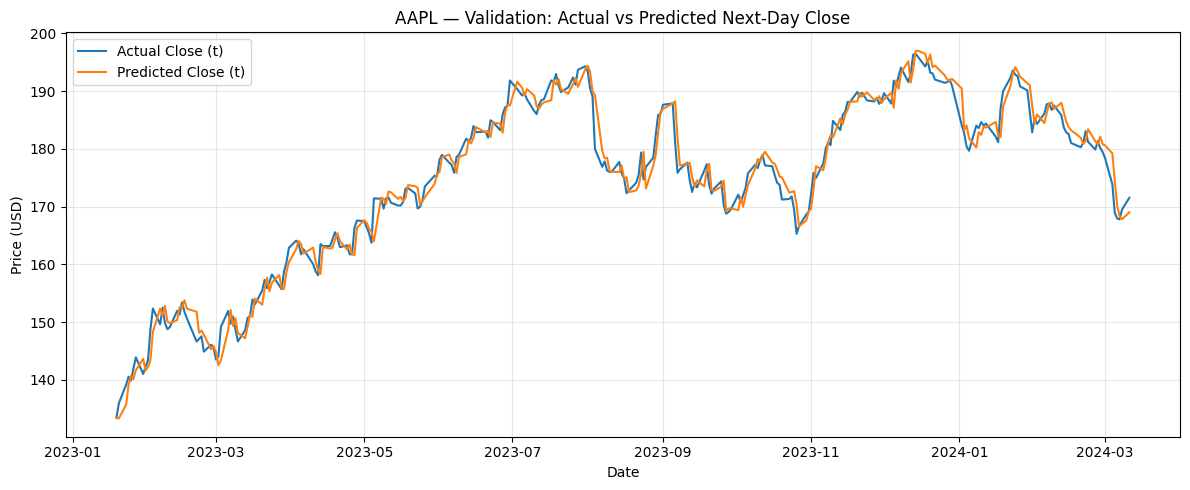

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(val_dates, true_next_close, label="Actual Close (t)", linewidth=1.5)
plt.plot(val_dates, pred_next_close, label="Predicted Close (t)", linewidth=1.5)
plt.title(f"{TICKER} — Validation: Actual vs Predicted Next-Day Close")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


In [39]:
import os, json, joblib
from tensorflow import keras

BASE_DIR = "models/base_aapl"
os.makedirs(BASE_DIR, exist_ok=True)

# 1) Save model (native Keras format)
keras_model_path = os.path.join(BASE_DIR, "model.keras")
model.save(keras_model_path)

# 2) Save scaler used for standardizing LogRet (fit on TRAIN of AAPL)
scaler_path = os.path.join(BASE_DIR, "scaler.pkl")
joblib.dump(scaler, scaler_path)

# 3) Minimal config (for provenance)
cfg = {
    "pipeline": "univariate_log_return",
    "ticker": "AAPL",
    "lookback": LOOKBACK,
    "trim_years": TRIM_YEARS,
    "calendar": "XNYS",
    "feature": "Close",
    "target": "LogRet"
}
with open(os.path.join(BASE_DIR, "config.json"), "w") as f:
    json.dump(cfg, f, indent=2)

print("✅ Exported:", keras_model_path, scaler_path)


✅ Exported: models/base_aapl\model.keras models/base_aapl\scaler.pkl


## Predict for N number of days 

In [41]:
try:
    raw = input(f"Enter number of FUTURE trading days to forecast (1–{MAX_FUTURE_DAYS}) "
                f"[Enter = {N_FUTURE}]: ").strip() # Use N_FUTURE instead of N_FUTURE_DEF
except EOFError:
    raw = ""

if raw == "":
    N_FUTURE_USER = int(N_FUTURE) # Use N_FUTURE instead of N_FUTURE_DEF
else:
    try:
        n = int(raw)
        if not (1 <= n <= MAX_FUTURE_DAYS):
            raise ValueError
        N_FUTURE_USER = n
    except Exception:
        print(f"⚠️ Invalid input. Falling back to default {N_FUTURE}.") # Use N_FUTURE instead of N_FUTURE_DEF
        N_FUTURE_USER = int(N_FUTURE) # Use N_FUTURE instead of N_FUTURE_DEF

print(f"✅ Forecast horizon: {N_FUTURE_USER} trading days")

✅ Forecast horizon: 50 trading days


In [42]:
def forecast_n_days_returns_to_price(
    model,
    scaler,
    close_series: pd.Series,
    scaled_ret_splits,      # (train_scaled, val_scaled, test_scaled)
    n_future: int,
    lookback: int,
    calendar: str,
):
    train_scaled, val_scaled, test_scaled = scaled_ret_splits
    combined_std = pd.concat([train_scaled["LogRet"], val_scaled["LogRet"], test_scaled["LogRet"]]).sort_index()
    if len(combined_std) < lookback:
        raise ValueError("Not enough history to seed the window.")
    window = combined_std.values[-lookback:].astype(np.float32).reshape(lookback, 1)

    last_close = float(close_series.iloc[-1])
    last_date  = close_series.index.max()

    cal = mcal.get_calendar(calendar)
    start_d = (last_date + pd.Timedelta(days=1)).date()
    end_d   = (last_date + pd.DateOffset(days=max(10, n_future*3))).date()
    sched = cal.schedule(start_date=start_d, end_date=end_d)
    future_days = sched.index
    if getattr(future_days, "tz", None) is not None:
        future_days = future_days.tz_localize(None)
    future_days = pd.DatetimeIndex(future_days)[:n_future]
    if len(future_days) < n_future:
        raise ValueError("Calendar did not return enough future trading days.")

    preds_std, preds_log, preds_close = [], [], []
    prev_close = last_close
    cur_window = window.copy()

    for _ in range(n_future):
        y_hat_std = float(model.predict(cur_window.reshape(1, lookback, 1), verbose=0).ravel()[0])
        y_hat_log = float(scaler.inverse_transform([[y_hat_std]])[0,0])
        next_close = prev_close * np.exp(y_hat_log)

        preds_std.append(y_hat_std); preds_log.append(y_hat_log); preds_close.append(next_close)
        cur_window = np.vstack([cur_window[1:], [[y_hat_std]]])  # slide with predicted std return
        prev_close = next_close

    out = pd.DataFrame({"pred_logret": preds_log, "pred_close": preds_close}, index=future_days)
    out.index.name = "date"
    return out

forecast_df = forecast_n_days_returns_to_price(
    model=model, scaler=scaler,
    close_series=close_df["Close"],
    scaled_ret_splits=(train_scaled, val_scaled, test_scaled),
    n_future=N_FUTURE_USER, lookback=LOOKBACK, calendar=CALENDAR,
)

print("✅ Forecast ready:")
display(forecast_df.head()); display(forecast_df.tail())


✅ Forecast ready:


,pred_logret,pred_close
date,,
2025-09-15,-0.003905,233.157656
2025-09-16,-0.005610,231.853392
2025-09-17,-0.001832,231.429070
2025-09-18,0.000232,231.482652
2025-09-19,-0.006497,229.983601


,pred_logret,pred_close
date,,
2025-11-17,0.003381,228.991539
2025-11-18,0.002184,229.492296
2025-11-19,0.001426,229.819806
2025-11-20,0.001084,230.068962
2025-11-21,0.001407,230.392950


In [44]:
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)
csv_path = os.path.join(ARTIFACT_DIR, f"forecast_{TICKER.upper()}_{N_FUTURE_USER}d_{pd.Timestamp.today().date()}.csv")
forecast_df.to_csv(csv_path, float_format="%.6f")
print(f"✅ Saved forecast CSV → {csv_path}")

tidy = forecast_df.copy()
tidy["pred_close"] = tidy["pred_close"].round(4)
tidy["pred_logret_%"] = (np.exp(tidy["pred_logret"]) - 1.0) * 100.0
display(tidy[["pred_close", "pred_logret_%"]])


✅ Saved forecast CSV → artifacts\forecast_AAPL_50d_2025-09-14.csv


,pred_close,pred_logret_%
date,,
2025-09-15,233.1577,-0.389777
2025-09-16,231.8534,-0.559392
2025-09-17,231.4291,-0.183013
2025-09-18,231.4827,0.023153
2025-09-19,229.9836,-0.647587
2025-09-22,228.3293,-0.719320
2025-09-23,226.5872,-0.762988
2025-09-24,224.7047,-0.830792
2025-09-25,222.8529,-0.824105


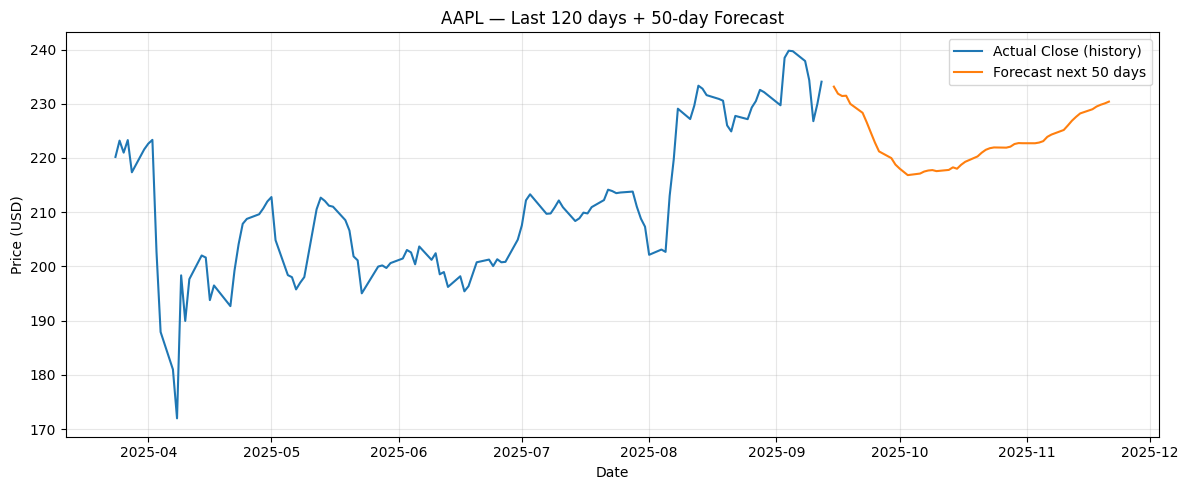

In [45]:
hist_days = 120
hist = close_df.tail(hist_days).copy()

plt.figure(figsize=(12,5))
plt.plot(hist.index, hist["Close"], label="Actual Close (history)")
plt.plot(forecast_df.index, forecast_df["pred_close"], label=f"Forecast next {N_FUTURE_USER} days")
plt.title(f"{TICKER} — Last {hist_days} days + {N_FUTURE_USER}-day Forecast")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()
